<img src="https://m1.quebecormedia.com/emp/emp/bender8175858f-7dbd-4927-85c5-85557e800b98_ORIGINAL.jpg?impolicy=crop-resize&x=0&y=0&w=1000&h=745&width=925&height=925" style="float: left; margin: 30px; height: 75px">

# Predicting H1N1 and Seasonal Flu Vaccination

## Neural Network Model 
### Lavanya Acharya , Katrin Ayrapetov, Sean Li


<font style="font-size: 2rem; color: blue">


 
</font>

In [59]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import os
import gc
import joblib
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

In [62]:
from sklearn import preprocessing

In [63]:
from sklearn import model_selection

<font style="font-size: 2rem; color: blue">

Predicting H1N1 Flu Vaccinations 
   
 
</font>

In [94]:
#This is the training data provided by DrivenData.com
df = pd.read_csv("../data/train_clean.csv")
df.drop(columns=["respondent_id"],inplace=True)
#This is the test data provided by DrivenData.com
df_submit = pd.read_csv("../data/submissions_data_clean.csv")
ids = df_submit.respondent_id.values
df_submit.drop(columns=["respondent_id"],inplace=True)

In [95]:
#Make 1 : Did not get the vaccine 0 : Did get the vaccine for both H1N1 and Seasonal Vaccine Data 

df['h1n1_vaccine'] = np.where(df['h1n1_vaccine'] == 1, 0, 1)


In [96]:
#initiate the kfold class from model_selection module
#The folds are made by preserving the percentage of samples for each class.
kf = model_selection.StratifiedKFold(n_splits=5)

In [97]:
#Create a column to hold kfold labels 
df["kfold"] = -1

In [98]:
#Reshuffle the rows. 
df = df.sample(frac=1).reset_index(drop=True)

In [99]:
#Create a target variable vector. 
y = df.h1n1_vaccine.values

In [100]:
for f, (t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,"kfold"] = f

In [101]:
# This function creates the Neural Network model using Entity embedding. 
def create_model(data, catcols):
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(45, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(45, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    y = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [102]:
# This function label encodes categorical features. It fits the training data with a model. 
# then uses the model to make predictions on the submissions data set. 
def fit_model_h1n1(fold):
     #create a list of just the categorical variables
    features = [f for f in df.columns if f not in ('household_adults','household_children','h1n1_vaccine', 'seasonal_vaccine', 'kfold')]
    #convert the categorical variables to strings
    for col in features:
        df.loc[:,col] = df[col].astype(str)  
    #Use label encoder on categorical features. 
    for feat in features:
        lbl_enc = preprocessing.LabelEncoder()
        df.loc[:,feat]=lbl_enc.fit_transform(df[feat].values)
     #convert the categorical variables to strings   
    for col in features:
        df_submit.loc[:,col] = df_submit[col].astype(str)
    #Use label encoder on categorical features. 
    for feat in features:
        lbl_enc_submit = preprocessing.LabelEncoder()
        df_submit.loc[:,feat]=lbl_enc_submit.fit_transform(df_submit[feat].values)
        
        
    #Hold one of the five folds as validation set and four folds as training sets 
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    model = create_model(df,features)
    # Features 
    xtrain = [
     df_train[features].values[:, k] for k in range(len(features))
    ]
    xvalid = [
    df_valid[features].values[:, k] for k in range(len(features))
    ]
    x_whole_train = [
    df[features].values[:, k] for k in range(len(features))
    ]
    xsubmit = [
    df_submit[features].values[:, k] for k in range(len(features))
    ]
    # get target columns
    ytrain = df_train.h1n1_vaccine.values
    yvalid = df_valid.h1n1_vaccine.values
    
    # convert target columns to categories

    ytrain_cat = utils.to_categorical(ytrain)
    yvalid_cat = utils.to_categorical(yvalid)
    
    # fit the model
    model.fit(xtrain,
    ytrain_cat,
    validation_data=(xvalid, yvalid_cat),
    verbose=0,
    batch_size=32,
    epochs=100)
    
    valid_preds = model.predict(xvalid)[:, 1]
    train_whole_pred_h1n1 = model.predict(x_whole_train)[:,1]
    submission_pred_h1n1 = model.predict(xsubmit)[:,1]
    auc = metrics.roc_auc_score(yvalid, valid_preds)
    print(f"For fold = {fold}, AUC = {auc}")
    # The output is the predictor vector for the training data set and for the submission data set. 
    return train_whole_pred_h1n1, submission_pred_h1n1


<font style="font-size: 2rem; color: blue">

Results for predicting Seasonal Flu Vaccine . 
   
   
 
</font>

In [104]:
print("The Neural Network results for predicting H1N1 Flu")
train_whole_pred_h1n1, submission_pred_h1n1 = fit_model_h1n1(1)

The Neural Network results for predicting H1N1 Flu
For fold = 1, AUC = 0.86089431396592


In [93]:
#Get the accuracy, recall and precision scores for the H1N1 predictions. 

accuracy_h1n1 = metrics.accuracy_score(df_train_results_.true_h1n1.values,df_train_results_.estimated_h1n1_class.values)
print(accuracy_h1n1)

recall_h1n1 = metrics.recall_score(df_train_results_.true_h1n1.values,df_train_results_.estimated_h1n1_class.values)
print(recall_h1n1)
precision_h1n1 = metrics.precision_score(df_train_results_.true_h1n1.values,df_train_results_.estimated_h1n1_class.values)
print(precision_h1n1)

0.28842625528887555
0.8808600634473035
0.21426734116436594


<font style="font-size: 2rem; color: blue">

Predicting Seasonal Flu Vaccinations 
   
 
</font>

In [74]:
#This is the training data provided by DrivenData.com
df = pd.read_csv("../data/train_clean.csv")
df.drop(columns=["respondent_id"],inplace=True)


In [75]:
#This is the test data provided by DrivenData.com
df_submit = pd.read_csv("../data/submissions_data_clean.csv")

df_submit.drop(columns=["respondent_id"],inplace=True)

In [76]:
#Make 1 : Did not get the vaccine 0 : Did get the vaccine for both H1N1 and Seasonal Vaccine Data
df['seasonal_vaccine'] = np.where(df['seasonal_vaccine'] == 1, 0, 1)

In [77]:
#Use the values predicted for H1N1 vaccinations from the previous step, as an additional feature
#to use in order to predict seasonal vaccine values. 
df["h1n1_pred"] = train_whole_pred_h1n1

In [78]:
#Use the values predicted for H1N1 vaccinations from the previous step, as an additional feature
#to use in order to predict seasonal vaccine values. 
df_submit["h1n1_pred"] = submission_pred_h1n1

In [79]:
#initiate the kfold class from model_selection module
kf_seas = model_selection.StratifiedKFold(n_splits=5)

In [80]:
#Create a column to hold kfold labels
df["kfold_seas"] = -1

In [81]:
 #Reshuffle the rows. 
df = df.sample(frac=1).reset_index(drop=True)

In [82]:
#Create a target variable vector.
y = df.seasonal_vaccine.values

In [83]:
for f, (t_,v_) in enumerate(kf_seas.split(X=df,y=y)):
    df.loc[v_,"kfold_seas"] = f

In [84]:
# This function creates the Neural Network model using Entity embedding. 

def create_model(data, catcols):
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(45, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(45, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    y = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [85]:
# This function label encodes categorical features. It fits the training data with a model. 
# then uses the model to make predictions on the submissions data set. 
def fit_model_seas(fold):
     #create a list of just the categorical variables
    features = [f for f in df.columns if f not in ('household_adults','household_children','h1n1_vaccine', 'seasonal_vaccine', 'kfold_seas',"h1n1_pred","h1n1_pred")]
    #convert the categorical variables to strings
    for col in features:
        df.loc[:,col] = df[col].astype(str)
    #Use label encoder on categorical features. 
    for feat in features:
        lbl_enc = preprocessing.LabelEncoder()
        df.loc[:,feat]=lbl_enc.fit_transform(df[feat].values)
    #convert the categorical variables to strings  
    for col in features:
        df_submit.loc[:,col] = df_submit[col].astype(str)
    #Use label encoder on categorical features. 
    for feat in features:
        lbl_enc_submit = preprocessing.LabelEncoder()
        df_submit.loc[:,feat]=lbl_enc_submit.fit_transform(df_submit[feat].values)
        
    #Hold one of the five folds as validation set and four folds as training sets 
    df_train = df[df.kfold_seas != fold].reset_index(drop=True)
    df_valid = df[df.kfold_seas == fold].reset_index(drop=True)
    model = create_model(df,features)
    # our features are lists of lists
    xtrain = [
     df_train[features].values[:, k] for k in range(len(features))
    ]
    xvalid = [
    df_valid[features].values[:, k] for k in range(len(features))
    ]
    x_whole_train = [
    df[features].values[:, k] for k in range(len(features))
    ]
    xsubmit = [
    df_submit[features].values[:, k] for k in range(len(features))
    ]
    # get target columns
    ytrain = df_train.seasonal_vaccine.values
    yvalid = df_valid.seasonal_vaccine.values
    # convert target columns to categories

    ytrain_cat = utils.to_categorical(ytrain)
    yvalid_cat = utils.to_categorical(yvalid)
    
    # fit the model
    model.fit(xtrain,
    ytrain_cat,
    validation_data=(xvalid, yvalid_cat),
    verbose=0,
    batch_size=32,
    epochs=100)
    valid_preds = model.predict(xvalid)[:, 1]
    train_whole_pred_seasonal = model.predict(x_whole_train)[:,1]
    submission_pred_seas = model.predict(xsubmit)[:,1]
    auc = metrics.roc_auc_score(yvalid, valid_preds)
    print(f"For fold = {fold}, AUC = {auc}")
    # The output is the predictor vector for the training data set and for the submission data set.
    return train_whole_pred_seasonal,submission_pred_seas

<font style="font-size: 2rem; color: blue">

Results for predicting Seasonal Flu Vaccine . 
   
 
</font>

In [86]:
print("The Neural Network results for predicting Seasonal Flu")
train_whole_pred_seasonal,submission_pred_seas =  fit_model_seas(3)
    

The Neural Network results for predicting Seasonal Flu
For fold = 3, AUC = 0.8644220443855349


In [87]:
df_train_results_ = pd.DataFrame(data=[df.h1n1_vaccine.values,train_whole_pred_h1n1,df.seasonal_vaccine.values,train_whole_pred_seasonal]).T
df_train_results_ .columns=["true_h1n1","estimated_h1n1_prob","true_seasonal","estimated_seasonal_prob"]

In [88]:
# In order to calculate accuracy, recall and precision, first binarize the target predictions. 

df_train_results_['estimated_seasonal_class'] = np.where(df_train_results_['estimated_seasonal_prob'] >= 0.5, 1, 0)

In [90]:
#Get the accuracy, recall and precision scores for the H1N1 predictions. 
accuracy_seasonal = metrics.accuracy_score(df_train_results_.true_seasonal.values,df_train_results_.estimated_seasonal_class.values)
print(accuracy_seasonal)
recall_seasonal = metrics.recall_score(df_train_results_.true_seasonal.values,df_train_results_.estimated_seasonal_class.values)
print(recall_seasonal)
precision_seasonal = metrics.precision_score(df_train_results_.true_seasonal.values,df_train_results_.estimated_seasonal_class.values)
print(precision_seasonal)

0.7997528737784102
0.8340106502242153
0.7998252922994221


In [51]:
#For the DrivenData.com submission, change the target variables back to 1: received the vaccine, 0: Did not receive the vaccine
df_submissions["h1n1_vaccine"] = 1 - df_submissions["h1n1_vaccine"]
df_submissions["seasonal_vaccine"] = 1 - df_submissions["seasonal_vaccine"]

In [49]:
#Create a data frame for DrivenData.com submission. 
df_submissions = pd.DataFrame(data=[ids,submission_pred_h1n1,submission_pred_seas]).T
df_submissions.columns=["respondent_id","h1n1_vaccine","seasonal_vaccine"]

In [53]:
#Create a .csv file for submission. 
df_submissions.to_csv('../data/April_27_10_00am.csv', index=False)

The submission to DrivenData.com results in AUC of 0.8578. and the current leading AUC metric  is 0.8658. 
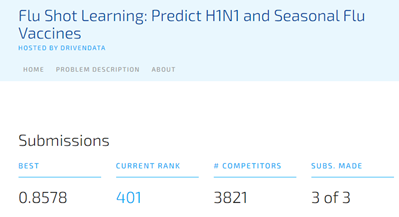

